In [1]:
# import pandas as pd
import csv
import numpy as np
import os
import copy
from os.path import join as pjoin
from glob import iglob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
root_path = '/data/ksb/'
bert_root_path = pjoin(root_path, 'BertSum/PreSumm')
bert_model_dir = pjoin(bert_root_path, 'models')

data_dir = pjoin(root_path, 'cnn-dailymail/finished_files')

three_data_dir = pjoin(root_path, 'three-mat')
three_data_test = pjoin(three_data_dir, 'test')

#### Loss function 비교  

*Trained Model parameter 필요*


In [3]:
def get_cos_similarity(inputs, summaries):
    tfidf_vectorizer = TfidfVectorizer()

    cos_similarity_list = []
    for input_, summary_ in zip(inputs, summaries):
        try:
            tfidf_matrix = tfidf_vectorizer.fit_transform([input_, summary_])

            similarity = cosine_similarity(tfidf_matrix[0] , tfidf_matrix[1])[0][0]
        except ValueError:
            similarity = 0.0
            
        cos_similarity_list.append(similarity)

    return cos_similarity_list

In [4]:
import jsonlines
import json

data_list = []
for data_p in iglob(pjoin(three_data_test, '**.json'), recursive=False):
    
    with open(data_p,'r',encoding='utf-8') as f:
        data = json.load(f)
        data_list.append(data)

### Origin candidate set

In [5]:
from rouge import Rouge
rouge = Rouge()

In [6]:
from transformers import BertTokenizer
tok = BertTokenizer.from_pretrained('bert-base-uncased', verbose=False)

def bert_encode(x, max_len=-1):
    cls_token_id = tok.cls_token_id
    sep_token_id = tok.sep_token_id

    _ids = tok.encode(x, add_special_tokens=False)
    ids = [cls_token_id] # [CLS]
    if max_len > 0:
        ids.extend(_ids[:max_len - 2])
    else:
        ids.extend(_ids[:512 - 2])
    ids.append(sep_token_id) # [SEP], meaning end of sentence
    return ids

def bert_decode(x):
    result = tok.decode(x, skip_special_tokens=True)
    return result

In [7]:
def detect_trigram(src, tgt):
    if len(tgt) < 3 or len(src) < 3:
        return False
    
    tgt_trigrams = [(tgt[i-1],tgt[i],tgt[i+1]) for i in range(1,len(tgt)-1)]
    src_trigrams = [(src[i-1],src[i],src[i+1]) for i in range(1,len(src)-1)]
    
    for src_tri in src_trigrams:
        if src_tri in tgt_trigrams:
            return True ## Detect trigram overlapped with target
        
    return False
    

In [8]:
def detect_4_gram(src, tgt):
    if len(tgt) < 4 or len(src) < 4:
        return False
    
    tgt_4_grams = [(tgt[i-2], tgt[i-1],tgt[i],tgt[i+1]) for i in range(2,len(tgt)-1)]
    src_4_grams = [(src[i-2], src[i-1],src[i],src[i+1]) for i in range(2,len(src)-1)]
    
    for src_gram in src_4_grams:
        if src_gram in tgt_4_grams:
            return True ## Detect 4-gram overlapped with target
        
    return False
    

In [9]:
def detect_5_gram(src, tgt):
    if len(tgt) < 5 or len(src) < 5:
        return False
    
    tgt_5_grams = [(tgt[i-2], tgt[i-1],tgt[i],tgt[i+1], tgt[i+2]) for i in range(2,len(tgt)-2)]
    src_5_grams = [(src[i-2], src[i-1],src[i],src[i+1], src[i+2]) for i in range(2,len(src)-2)]
    
    for src_gram in src_5_grams:
        if src_gram in tgt_5_grams:
            return True ## Detect 5-gram overlapped with target
        
    return False

In [10]:
def detect_ngram_list(src, tgt_list, n_gram='trigram'):
    
    if n_gram =='trigram':
        return sum([detect_trigram(src, tgt) for tgt in tgt_list]) > 0
    elif n_gram =='4-gram':
        return sum([detect_4_gram(src, tgt) for tgt in tgt_list]) > 0
    else :
        return sum([detect_4_gram(src, tgt) for tgt in tgt_list])>0

In [11]:
def get_candidate_set(sent_set, n_gram='trigram'):
    
    assert n_gram in ['trigram', '4-gram','5-gram']
        
    if n_gram == 'trigram':
        detect_ngram = detect_trigram
    elif n_gram == '4-gram':
        detect_ngram = detect_4_gram
    else:
        detect_ngram = detect_5_gram
        
    
    possible_set_ids = []
    
    for sent_id, sent, txt_sent in sent_set:
        possible_2_sent_idx = []
        
        # number of summary sentences = 2
        for tgt_sent_id, tgt_sent, tgt_sent_txt in sent_set[sent_id+1:]:
            
            # Detect n-gram (default= trigram) 
            if not detect_ngram(src=sent, tgt=tgt_sent):
                possible_2_sent_idx.append(set([sent_id, tgt_sent_id]))
                
        possible_3_sent_idx = copy.deepcopy(possible_2_sent_idx)
        
        # number of summary sentences = 3
        for tgt_sent_id, tgt_sent, tgt_sent_txt in sent_set[sent_id+1:]:
            for poss_sent_ids in possible_2_sent_idx:
                
                poss_sent = [sent_set[ids][1] for ids in poss_sent_ids]
                if not detect_ngram_list(src=tgt_sent, tgt_list=poss_sent, n_gram=n_gram):
                    poss_3_ids = copy.deepcopy(poss_sent_ids)
                    poss_3_ids.add(tgt_sent_id)
                    
                    possible_3_sent_idx.append(poss_3_ids)
                    
        possible_sent_idx = possible_2_sent_idx + possible_3_sent_idx
        
        for ids in possible_sent_idx:
            if not ids in possible_set_ids:
                possible_set_ids.append(ids)

    return possible_set_ids
        

In [12]:
def get_sent_level_candidaet(sent_set, reference, n_gram='trigram'):
    
    assert n_gram in ['trigram', '4-gram','5-gram']
        
    if n_gram == 'trigram':
        detect_ngram = detect_trigram
    elif n_gram == '4-gram':
        detect_ngram = detect_4_gram
    else:
        detect_ngram = detect_5_gram
        
    
    possible_set_ids = []
    
    for sent_id, sent, txt_sent in sent_set:
        possible_2_sent_idx = []
        
        # number of summary sentences = 2
        for tgt_sent_id, tgt_sent, tgt_sent_txt in sent_set[sent_id+1:]:
            
            # Detect n-gram (default= trigram) 
            if not detect_ngram(src=sent, tgt=tgt_sent):
                possible_2_sent_idx.append(set([sent_id, tgt_sent_id]))
                
        possible_3_sent_idx = copy.deepcopy(possible_2_sent_idx)
        
        # number of summary sentences = 3
        for tgt_sent_id, tgt_sent, tgt_sent_txt in sent_set[sent_id+1:]:
            for poss_sent_ids in possible_2_sent_idx:
                
                poss_sent = [sent_set[ids][1] for ids in poss_sent_ids]
                if not detect_ngram_list(src=tgt_sent, tgt_list=poss_sent, n_gram=n_gram):
                    poss_3_ids = copy.deepcopy(poss_sent_ids)
                    poss_3_ids.add(tgt_sent_id)
                    
                    possible_3_sent_idx.append(poss_3_ids)
                    
        possible_sent_idx = possible_2_sent_idx + possible_3_sent_idx
        
        for ids in possible_sent_idx:
            if not ids in possible_set_ids:
                possible_set_ids.append(ids)

    return possible_set_ids

In [13]:
import pylcs

def compute_txt_redundancy_score(candidate_id):

    cand_num = len(candidate_id)
    
    score = torch.zeros([cand_num], dtype=torch.float64)
        
    def _compute_redundancy(cand):
        redundancy = 0.0
        
        for i, src_sen in enumerate(cand):
            for j, tgt_sen in enumerate(cand[i+1:]):
                if i != j:
                    lcs_val = pylcs.lcs(src_sen, tgt_sen)
                    redundancy += lcs_val 
        
        sents_len = sum([len(s) for sents in cand for s in sents])
        return redundancy / sents_len

    for i in range(cand_num):
        score[i] = np.mean(_compute_redundancy(candidate_id[i]))

    return score

In [22]:
def get_rouge(src, tgt, rouge_score='rouge-1'):
    sc = rouge.get_scores(' '.join(src), ' '.join(tgt))[0][rouge_score]
    sc = np.mean([sc['f'], sc['p'], sc['r']])
    return sc

In [21]:
def get_sent_lvl_rouge(src, tgt, rouge_score='rouge-1'):
    score = 0.0
    for t in tgt:
        score += get_rouge(src, [t], rouge_score=rouge_score)
    score /= len(tgt)
    return score

In [76]:
# Origin Candidate
origin_ref_rouges = []
origin_redun_scores = []

origin_doc_sims = []
origin_ref_sims = []


# Reconstructed Candidate
refine_ref_rouges = []
refine_redun_scores = []

refine_doc_sims = []
refine_ref_sims = []


In [60]:
bart_sent_lvl_score = []
refactor_sent_lvl_score = []
gsum_sent_lvl_score = []

bart_summ_lvl_score = []
refactor_summ_lvl_score = []
gsum_summ_lvl_score = []

for i, data in enumerate(data_list):
    candidates = data['candidates']
    article = data['article']
    abstract = data["abstract"]
    
    
    bart_sent_lvl_score.append(get_sent_lvl_rouge(abstract, candidates[0][0]))
    refactor_sent_lvl_score.append(get_sent_lvl_rouge(abstract, candidates[1][0]))
    gsum_sent_lvl_score.append(get_sent_lvl_rouge(abstract, candidates[2][0]))
    
    bart_summ_lvl_score.append(get_rouge(abstract, candidates[0][0]))
    refactor_summ_lvl_score.append(get_rouge(abstract, candidates[1][0]))
    gsum_summ_lvl_score.append(get_rouge(abstract, candidates[2][0]))
    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707


5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350


6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002


8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642


10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
1023

11441
11442
11443
11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489


In [66]:
import seaborn as sns
import pandas as pd

snt_lvl_scores = pd.DataFrame(columns=['candidate', 'bart', 'refactor', 'gsum'])
for idx, (b, r, g, bs, rs, gs) in enumerate(zip(bart_sent_lvl_score, refactor_sent_lvl_score, gsum_sent_lvl_score,
                                   bart_summ_lvl_score, refactor_summ_lvl_score, gsum_summ_lvl_score)):
    dic = {'candidate' : int(idx),
           'bart' : b,
           'refactor' : r,
           'gsum' : g,
            'bart_sum' : bs,
           'refactor_sum' : rs,
           'gsum_sum' : gs
          }
    snt_lvl_scores = snt_lvl_scores.append(dic, ignore_index=True)
snt_lvl_scores

,candidate,bart,refactor,gsum,bart_sum,gsum_sum,refactor_sum
0,0.0,0.339256,0.352210,0.346757,0.469559,0.486432,0.558884
1,1.0,0.345629,0.285035,0.274906,0.414707,0.375435,0.364313
2,2.0,0.263451,0.294728,0.223571,0.377448,0.293991,0.360056
3,3.0,0.325763,0.314987,0.315744,0.469518,0.491617,0.513966
4,4.0,0.215571,0.234952,0.132659,0.247207,0.222713,0.339664
...,...,...,...,...,...,...,...
11485,11485.0,0.209334,0.228246,0.253064,0.262918,0.330774,0.330774
11486,11486.0,0.291135,0.229451,0.290600,0.437766,0.434788,0.370710
11487,11487.0,0.266827,0.353928,0.254022,0.302451,0.297598,0.511602
11488,11488.0,0.342449,0.232636,0.344351,0.492438,0.479189,0.333469


In [154]:

import matplotlib.pyplot as plt
import seaborn as sns

bart_dist = snt_lvl_scores.drop(columns=['candidate','refactor', 'gsum', 'bart_sum', 'refactor_sum', 'gsum_sum'])
ref_dist = snt_lvl_scores.drop(columns=['candidate','bart', 'gsum', 'bart_sum', 'refactor_sum', 'gsum_sum'])
gsum_dist = snt_lvl_scores.drop(columns=['candidate', 'refactor', 'bart', 'bart_sum', 'refactor_sum', 'gsum_sum'])

plt.rcParams["figure.figsize"] = (16,8)

sns.distplot(ref_dist, label='bart')
sns.distplot(gsum_dist, label='gsum')
sns.distplot(bart_dist, label='refactor')
plt.legend()

# fig.legend(labels=['refactor', 'gsum', 'bart'], fontsize=14)
plt.show()


NameError: name 'snt_lvl_scores' is not defined

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

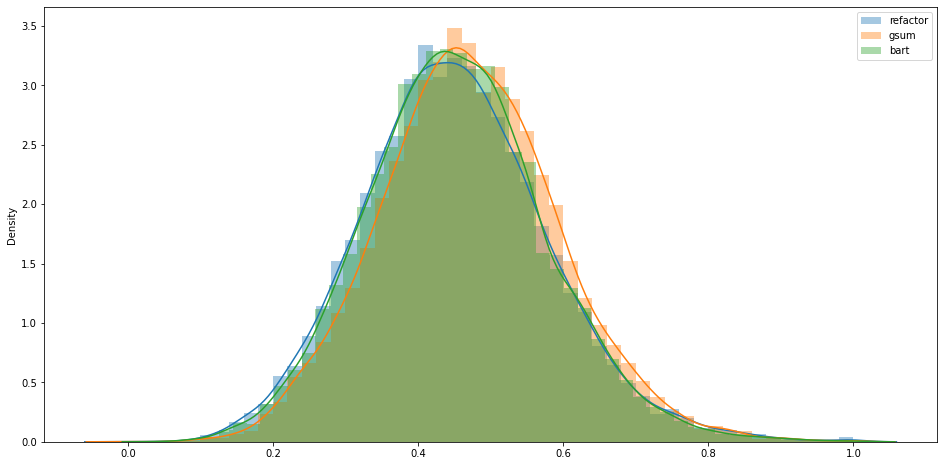

In [76]:

bart_sum_dist = snt_lvl_scores.drop(columns=['candidate','refactor', 'gsum', 'bart', 'refactor_sum', 'gsum_sum'])
ref_sum_dist = snt_lvl_scores.drop(columns=['candidate','bart', 'gsum', 'bart_sum', 'refactor', 'gsum_sum'])
gsum_sum_dist = snt_lvl_scores.drop(columns=['candidate', 'refactor', 'bart', 'bart_sum', 'refactor_sum', 'gsum'])

plt.rcParams["figure.figsize"] = (16,8)

sns.distplot(ref_sum_dist, label='refactor')
sns.distplot(gsum_sum_dist, label='gsum')
sns.distplot(bart_sum_dist, label='bart')
plt.legend()

# fig.legend(labels=['refactor', 'gsum', 'bart'], fontsize=14)
plt.show()


In [152]:
origin_cands = []
refine_cands = []
abstracts = []

print(len(data_list))
for i, data in enumerate(data_list):
    print(i)
    candidates = data['candidates']
    article = data['article']
    abstract = data["abstract"]


    summaries = [cand[0] for cand in candidates]    
    encoded_cand_set = [[bert_encode(s, 180) for s in cs] for cs in summaries]

    sent_set = []
    for i, encoded_cand in enumerate(encoded_cand_set):
        for j, encoded_sent in enumerate(encoded_cand):
        
            sent_id = sum([len(prev) for prev in encoded_cand_set[:i]])+j
            sent_set.append((sent_id, encoded_sent, candidates[i][0][j]))

    # Get Candidate 
    reduced_cand_ids = get_candidate_set(sent_set)
    reduced_cand_sents = [[sent_set[i][2] for i in ids] for ids in reduced_cand_ids]
    

    # Use Summary-level score
    
    origin_cand = [(get_rouge(abstract, cand[0]), cand[0]) for cand in candidates]
    origin_cand = sorted(origin_cand, key=lambda x: x[0], reverse=True)
    
    rouge_cands_set = []
    for c in reduced_cand_sents:
        score = get_rouge(abstract, c)
        rouge_cands_set.append((score, c))
    rouge_cands_set = sorted(rouge_cands_set, key=lambda x: x[0], reverse=True)

    # Use Summary-level score
    sent_lvl_rouge_cands_set = []
    for c in reduced_cand_sents:
        score = 0.0
        for s in c:
            score += get_rouge(abstract, [s])
        
        score /= len(c)
        sent_lvl_rouge_cands_set.append((score, c))
    
    sent_lvl_rouge_cands_set = sorted(sent_lvl_rouge_cands_set, key=lambda x: x[0], reverse=True)
    
    reconstructed_cands = [s[-1] for s in rouge_cands_set[:3]]
    reconstructed_snt_lvl_cands = [s[-1] for s in sent_lvl_rouge_cands_set[:3]]
        
    origin_cand_rouge = [round(cand[0],4) for cand in origin_cand]
    new_cand_rouge = [round(get_rouge(abstract, cand),4) for cand in reconstructed_cands]
    new_snt_lv_cand_rouge = [round(get_rouge(abstract, cand),4) for cand in reconstructed_snt_lvl_cands]
        
    
    abstracts.append(abstract)
    refine_cands.append(reconstructed_cands)
    origin_cands.append(origin_cand)
    

11490
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275


1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059


3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698


5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337


6778
6779
6780
6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977


8417
8418
8419
8420
8421
8422
8423
8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616


10047
10048
10049
10050
10051
10052
10053
10054
10055
10056
10057
10058
10059
10060
10061
10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
1021

11413
11414
11415
11416
11417
11418
11419
11420
11421
11422
11423
11424
11425
11426
11427
11428
11429
11430
11431
11432
11433
11434
11435
11436
11437
11438
11439
11440
11441
11442
11443
11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489


In [153]:
cands = [data['candidates'] for data in data_list]
cands = [[cand[0][0], cand[1][0], cand[2][0]] for cand in cands]

ref_per = []
ba_per = []
g_per = []
for re_cand, or_cands in zip(refine_cands, cands):
    ref = or_cands[0]
    bart = or_cands[1]
    gsum = or_cands[2]
    
    re_cand_best = re_cand[0]
    ref_cnt, ba_cnt, g_snt =0,0,0
    for s in re_cand_best:
        if s in ref:
            ref_cnt += 1            
        if s in bart:
            ba_cnt +=1
        if s in gsum:
            g_snt +=1
        if not (s in gsum or s in bart or s in ref) :
            print(s)
            print(or_cands)
            raise Exception
            
    r_p = ref_cnt / len(re_cand_best)
    b_p = ba_cnt / len(re_cand_best)
    g_p = g_snt / len(re_cand_best)
    
    assert r_p >= 0.0 and b_p >= 0.0 and g_p >= 0.0
    ref_per.append(r_p)
    ba_per.append(ba_cnt / len(re_cand_best))
    g_per.append(g_snt / len(re_cand_best))

IndexError: list index out of range

In [ ]:
plt.rcParams["figure.figsize"] = (16,8)

min_line = plt.axvline(x=0.0, color='dimgray', linewidth=1)

max_line = plt.axvline(x=1.0, color='dimgray', linewidth=1)

log_ref_per = np.log1p(ref_per)
log_ba_per = np.log1p(ba_per)
log_g_per = np.log1p(g_per)

sns.distplot(log_ref_per, label='ref_per', hist=False)
sns.distplot(log_ba_per, label='ba_per', hist=False)
sns.distplot(log_g_per, label='g_per', hist=False)
# x_range = np.arange(0, 1.1, step=1 / 10).tolist()
# plt.xticks(x_range, \
#            ["%.2f"%x for x in x_range])


# plt.plot(ref_per, label='ref_per')
# plt.plot(ba_per, label='ba_per') #, hist=False)
# plt.plot(g_per, label='g_per')#, hist=False)

plt.legend()

# fig.legend(labels=['refactor', 'gsum', 'bart'], fontsize=14)
plt.show()


In [ ]:
import scipy.stats as stats

plt.rcParams["figure.figsize"] = (16,8)

log_tok_dist = np.log1p(ref_per)

log_token_max = np.max(log_tok_dist)
log_token_min = np.min(log_tok_dist)

log_token_var = np.var(log_tok_dist)
log_token_std = np.std(log_tok_dist)
log_token_mean = np.mean(log_tok_dist)

print("Token Distribution : {} ~ {}".format(log_token_min, log_token_max))
print("Token Distribution Mean : {:.3f}\n".format(log_token_mean))
print("Variance : {:.2f} \nStandard Devidation: {:.2f}\n".format(log_token_var, log_token_std))

x = sorted(log_tok_dist)
norm_dist = stats.norm(log_token_mean, log_token_std)

log_L_95 = log_token_mean - 1.96*(log_token_std/np.sqrt(100))
log_U_95 = log_token_mean + 1.96*(log_token_std/np.sqrt(100))
print("95% Confidence Interval : {:.2f} ~ {:.2f}".format(np.expm1(log_L_95), np.expm1(log_U_95)))

log_L_99 = log_token_mean - 2.58*(log_token_std/np.sqrt(100))
log_U_99 = log_token_mean + 2.58*(log_token_std/np.sqrt(100))
print("99% Confidence Interval : {:.2f} ~ {:.2f}".format(np.expm1(log_L_99), np.expm1(log_U_99)))

pdf_line, = plt.plot(x, norm_dist.pdf(x), color='steelblue', linewidth=2)

mean_line = plt.axvline(x=log_token_mean, color='dimgray', linewidth=1)

plt.axvline(log_L_95, color='r', linestyle='--', linewidth=1)
plt.axvline(log_U_95, color='r', linestyle='--', linewidth=1)

plt.axvline(log_L_99, color='g', linestyle='--', linewidth=1)
plt.axvline(log_U_99, color='g', linestyle='--', linewidth=1)

step = 0.01
plt.fill_between(np.arange(log_token_min, log_L_99, step=step).tolist(), 
                 [norm_dist.pdf(i) for i in np.arange(log_token_min , log_L_99, step=step)], alpha=0.5, color='steelblue') 

confidence_99_area = plt.fill_between(np.arange(log_L_99 , log_L_95, step=step).tolist(), 
                 [norm_dist.pdf(i) for i in np.arange(log_L_99 , log_L_95, step=step)], alpha=0.5, color='chartreuse')

confidence_area = plt.fill_between(np.arange(log_L_95 , log_U_95, step=step).tolist(), 
                 [norm_dist.pdf(i) for i in np.arange(log_L_95 , log_U_95, step=step)], alpha=0.5, color='lightcoral')

confidence_99_area = plt.fill_between(np.arange(log_U_95 , log_U_99, step=step).tolist(), 
                 [norm_dist.pdf(i) for i in np.arange(log_U_95 , log_U_99, step=step)], alpha=0.5, color='chartreuse')

plt.fill_between(np.arange(log_U_99 , log_token_max, step=step).tolist(), 
                 [norm_dist.pdf(i) for i in np.arange(log_U_99 , log_token_max, step=step)], alpha=0.5, color='steelblue') 


plt.title("Density of Refactor output in Best new candidate", fontsize=15)

plt.xlabel('Percentage', fontsize=13)
plt.ylabel('Probability Density', fontsize=13)

plt.legend(handles=(pdf_line, mean_line, confidence_area, confidence_99_area), 
           labels=('PDF', "Mean", "95% Confidence Interval", "99% Confidence Interval"))


plt.show()

In [ ]:
import scipy.stats as stats

plt.rcParams["figure.figsize"] = (16,8)

log_tok_dist = np.log1p(ba_per)

log_token_max = np.max(log_tok_dist)
log_token_min = np.min(log_tok_dist)

log_token_var = np.var(log_tok_dist)
log_token_std = np.std(log_tok_dist)
log_token_mean = np.mean(log_tok_dist)

print("Token Distribution : {} ~ {}".format(log_token_min, log_token_max))
print("Token Distribution Mean : {:.3f}\n".format(log_token_mean))
print("Variance : {:.2f} \nStandard Devidation: {:.2f}\n".format(log_token_var, log_token_std))

x = sorted(log_tok_dist)
norm_dist = stats.norm(log_token_mean, log_token_std)

log_L_95 = log_token_mean - 1.96*(log_token_std/np.sqrt(100))
log_U_95 = log_token_mean + 1.96*(log_token_std/np.sqrt(100))
print("95% Confidence Interval : {:.2f} ~ {:.2f}".format(np.expm1(log_L_95), np.expm1(log_U_95)))

log_L_99 = log_token_mean - 2.58*(log_token_std/np.sqrt(100))
log_U_99 = log_token_mean + 2.58*(log_token_std/np.sqrt(100))
print("99% Confidence Interval : {:.2f} ~ {:.2f}".format(np.expm1(log_L_99), np.expm1(log_U_99)))

pdf_line, = plt.plot(x, norm_dist.pdf(x), color='steelblue', linewidth=2)

mean_line = plt.axvline(x=log_token_mean, color='dimgray', linewidth=1)

plt.axvline(log_L_95, color='r', linestyle='--', linewidth=1)
plt.axvline(log_U_95, color='r', linestyle='--', linewidth=1)

plt.axvline(log_L_99, color='g', linestyle='--', linewidth=1)
plt.axvline(log_U_99, color='g', linestyle='--', linewidth=1)


step = 0.01
plt.fill_between(np.arange(log_token_min, log_L_99, step=step).tolist(), 
                 [norm_dist.pdf(i) for i in np.arange(log_token_min , log_L_99, step=step)], alpha=0.5, color='steelblue') 

confidence_99_area = plt.fill_between(np.arange(log_L_99 , log_L_95, step=step).tolist(), 
                 [norm_dist.pdf(i) for i in np.arange(log_L_99 , log_L_95, step=step)], alpha=0.5, color='chartreuse')

confidence_area = plt.fill_between(np.arange(log_L_95 , log_U_95, step=step).tolist(), 
                 [norm_dist.pdf(i) for i in np.arange(log_L_95 , log_U_95, step=step)], alpha=0.5, color='lightcoral')

confidence_99_area = plt.fill_between(np.arange(log_U_95 , log_U_99, step=step).tolist(), 
                 [norm_dist.pdf(i) for i in np.arange(log_U_95 , log_U_99, step=step)], alpha=0.5, color='chartreuse')

plt.fill_between(np.arange(log_U_99 , log_token_max, step=step).tolist(), 
                 [norm_dist.pdf(i) for i in np.arange(log_U_99 , log_token_max, step=step)], alpha=0.5, color='steelblue') 


plt.title("Density of BART output in Best new candidate", fontsize=15)

plt.xlabel('Percentage', fontsize=13)
plt.ylabel('Probability Density', fontsize=13)


plt.legend(handles=(pdf_line, mean_line, confidence_area, confidence_99_area), 
           labels=('PDF', "Mean", "95% Confidence Interval", "99% Confidence Interval"))


plt.show()

In [ ]:
import scipy.stats as stats

plt.rcParams["figure.figsize"] = (16,8)

log_tok_dist = np.log1p(g_per)

log_token_max = np.max(log_tok_dist)
log_token_min = np.min(log_tok_dist)

log_token_var = np.var(log_tok_dist)
log_token_std = np.std(log_tok_dist)
log_token_mean = np.mean(log_tok_dist)

print("Token Distribution : {} ~ {}".format(log_token_min, log_token_max))
print("Token Distribution Mean : {:.3f}\n".format(log_token_mean))
print("Variance : {:.2f} \nStandard Devidation: {:.2f}\n".format(log_token_var, log_token_std))

x = sorted(log_tok_dist)
norm_dist = stats.norm(log_token_mean, log_token_std)

log_L_95 = log_token_mean - 1.96*(log_token_std/np.sqrt(100))
log_U_95 = log_token_mean + 1.96*(log_token_std/np.sqrt(100))
print("95% Confidence Interval : {:.2f} ~ {:.2f}".format(np.expm1(log_L_95), np.expm1(log_U_95)))

log_L_99 = log_token_mean - 2.58*(log_token_std/np.sqrt(100))
log_U_99 = log_token_mean + 2.58*(log_token_std/np.sqrt(100))
print("99% Confidence Interval : {:.2f} ~ {:.2f}".format(np.expm1(log_L_99), np.expm1(log_U_99)))

pdf_line, = plt.plot(x, norm_dist.pdf(x), color='steelblue', linewidth=2)

mean_line = plt.axvline(x=log_token_mean, color='dimgray', linewidth=1)

plt.axvline(log_L_95, color='r', linestyle='--', linewidth=1)
plt.axvline(log_U_95, color='r', linestyle='--', linewidth=1)

plt.axvline(log_L_99, color='g', linestyle='--', linewidth=1)
plt.axvline(log_U_99, color='g', linestyle='--', linewidth=1)


step = 0.01
plt.fill_between(np.arange(log_token_min, log_L_99, step=step).tolist(), 
                 [norm_dist.pdf(i) for i in np.arange(log_token_min , log_L_99, step=step)], alpha=0.5, color='steelblue') 

confidence_99_area = plt.fill_between(np.arange(log_L_99 , log_L_95, step=step).tolist(), 
                 [norm_dist.pdf(i) for i in np.arange(log_L_99 , log_L_95, step=step)], alpha=0.5, color='chartreuse')

confidence_area = plt.fill_between(np.arange(log_L_95 , log_U_95, step=step).tolist(), 
                 [norm_dist.pdf(i) for i in np.arange(log_L_95 , log_U_95, step=step)], alpha=0.5, color='lightcoral')

confidence_99_area = plt.fill_between(np.arange(log_U_95 , log_U_99, step=step).tolist(), 
                 [norm_dist.pdf(i) for i in np.arange(log_U_95 , log_U_99, step=step)], alpha=0.5, color='chartreuse')

plt.fill_between(np.arange(log_U_99 , log_token_max, step=step).tolist(), 
                 [norm_dist.pdf(i) for i in np.arange(log_U_99 , log_token_max, step=step)], alpha=0.5, color='steelblue') 


plt.title("Density of GSum output in Best new candidate", fontsize=15)

plt.xlabel('Percentage', fontsize=13)
plt.ylabel('Probability Density', fontsize=13)


plt.legend(handles=(pdf_line, mean_line, confidence_area, confidence_99_area), 
           labels=('PDF', "Mean", "95% Confidence Interval", "99% Confidence Interval"))


plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

result = pd.DataFrame(columns=['candidate', 'snt_best', 'summ_best', 'mean_snt','mean_summ'])

for i, (a, o, r) in enumerate(zip(abstracts, origin_cands, refine_cands)):
    
    best_origin_cand = o[0][1]
    best_new_cand = r[0]
    
    origin_summ_best = get_rouge(a, best_origin_cand)
    origin_snt_best = get_sent_lvl_rouge(a, best_origin_cand)
    
    summ_best = get_rouge(a, best_new_cand)
    snt_best = get_sent_lvl_rouge(a, best_new_cand)
    
    origin_summ_mean = np.mean([get_rouge(a, oo[1]) for oo in o])
    summ_mean = np.mean([get_rouge(a, rr) for rr in r])
    
    origin_snt_mean = np.mean([get_sent_lvl_rouge(a, oo[1]) for oo in o])
    snt_mean = np.mean([get_sent_lvl_rouge(a, rr) for rr in r])


    dic = {'candidate' : int(i),
            'snt_best' : snt_best,
            'origin_snt_best' : origin_snt_best,
           'summ_best' : summ_best,
           'origin_summ_best' : origin_summ_best,
           'mean_snt' : snt_mean,
           'origin_mean_snt' : origin_snt_mean,
           'mean_summ' : summ_mean,
           'origin_mean_summ' : origin_summ_mean
          }
    result = result.append(dic, ignore_index=True)
    

In [ ]:
snt_best = result.drop(columns=['candidate','origin_snt_best', 'summ_best', 'origin_summ_best', 'mean_snt', 
                                        'origin_mean_snt', 'mean_summ', 'origin_mean_summ'])
origin_snt_best = result.drop(columns=['candidate','snt_best', 'summ_best', 'origin_summ_best', 'mean_snt', 
                                        'origin_mean_snt', 'mean_summ', 'origin_mean_summ'])

plt.rcParams["figure.figsize"] = (16,8)

sns.distplot(snt_best, label='snt_best')
sns.distplot(origin_snt_best, label='origin_snt_best')
plt.legend()

# fig.legend(labels=['refactor', 'gsum', 'bart'], fontsize=14)
plt.show()


In [ ]:
summ_best = result.drop(columns=['candidate','origin_snt_best', 'snt_best', 'origin_summ_best', 'mean_snt', 
                                        'origin_mean_snt', 'mean_summ', 'origin_mean_summ'])
origin_summ_best = result.drop(columns=['candidate','snt_best', 'summ_best', 'origin_snt_best', 'mean_snt', 
                                        'origin_mean_snt', 'mean_summ', 'origin_mean_summ'])

plt.rcParams["figure.figsize"] = (16,8)

sns.distplot(summ_best, label='summ_best')
sns.distplot(origin_summ_best, label='origin_summ_best')
plt.legend()

# fig.legend(labels=['refactor', 'gsum', 'bart'], fontsize=14)
plt.show()

In [ ]:
mean_summ = result.drop(columns=['candidate','origin_snt_best', 'snt_best', 'origin_summ_best', 'mean_snt', 
                                        'origin_mean_snt', 'summ_best', 'origin_mean_summ'])
origin_mean_summ = result.drop(columns=['candidate','snt_best', 'summ_best', 'origin_snt_best', 'mean_snt', 
                                        'origin_mean_snt', 'mean_summ', 'origin_summ_best'])

plt.rcParams["figure.figsize"] = (16,8)

sns.distplot(mean_summ, label='mean_summ')
sns.distplot(origin_mean_summ, label='origin_mean_summ')
plt.legend()

# fig.legend(labels=['refactor', 'gsum', 'bart'], fontsize=14)
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

result_2 = pd.DataFrame(columns=['candidate', 'best_diff', 'mean_diff'])

for i, (a, o, r) in enumerate(zip(abstracts, origin_cands, refine_cands)):
    
    best_origin_cand = o[0][1]
    best_new_cand = r[0]
    
    origin_summ_best = get_rouge(abstract, best_origin_cand)
    origin_summ_mean = np.mean([get_rouge(abstract, oo[1]) for oo in o])
    
    summ_best = get_rouge(abstract, best_new_cand)
    summ_mean = np.mean([get_rouge(a, rr) for rr in r])
    
    best_diff = summ_best - origin_summ_best
    mean_diff = summ_mean - origin_summ_mean

    dic = {'candidate' : int(i),
            'best_diff' : best_diff,
            'mean_diff' : mean_diff
          }
    result_2 = result_2.append(dic, ignore_index=True)

In [ ]:
best_diff = result_2.drop(columns=['candidate','mean_diff'])

plt.rcParams["figure.figsize"] = (16,8)

sns.distplot(best_diff, label='best_diff')
plt.legend()

# fig.legend(labels=['refactor', 'gsum', 'bart'], fontsize=14)
plt.show()

In [ ]:
mean_diff = result_2.drop(columns=['candidate','best_diff'])

plt.rcParams["figure.figsize"] = (16,8)

sns.distplot(mean_diff, label='mean_diff')
plt.legend()

# fig.legend(labels=['refactor', 'gsum', 'bart'], fontsize=14)
plt.show()

In [ ]:
ref_cands = [data['candidates'][0][0] for data in data_list]
bart_cands = [data['candidates'][1][0] for data in data_list]
gsum_cands = [data['candidates'][2][0] for data in data_list]


/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


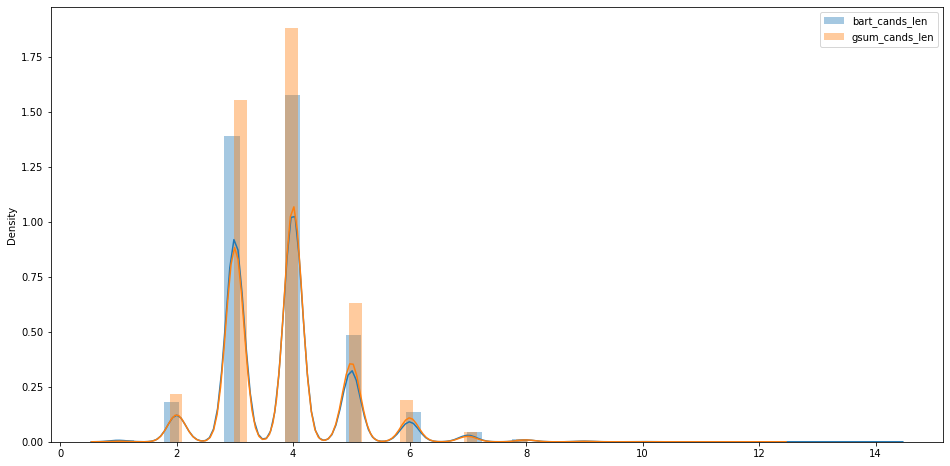

In [71]:
bart_cands_len = [len(d) for d in bart_cands]
gsum_cands_len = [len(d) for d in gsum_cands]

plt.rcParams["figure.figsize"] = (16,8)

sns.distplot(bart_cands_len, label='bart_cands_len')
sns.distplot(gsum_cands_len, label='gsum_cands_len')

plt.legend()
plt.show()

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


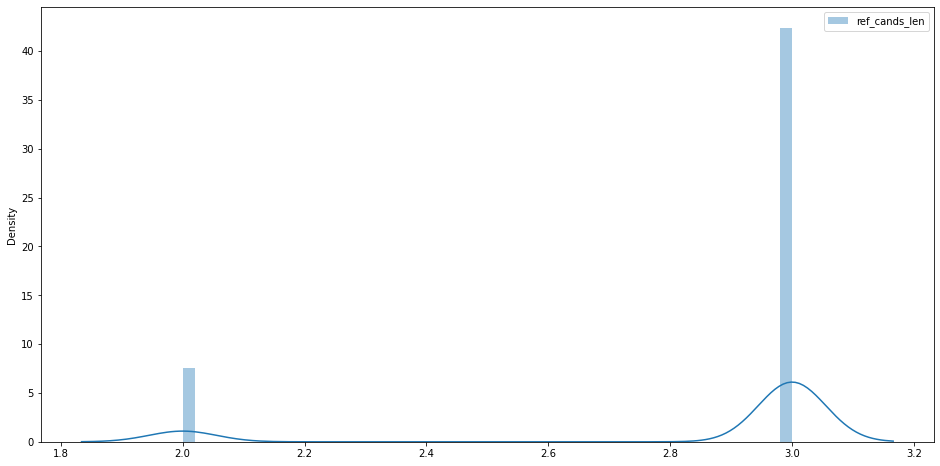

In [72]:
# bart_cands_len = [len(d) for d in bart_cands]
ref_cands_len = [len(d) for d in ref_cands]

plt.rcParams["figure.figsize"] = (16,8)

# sns.distplot(bart_cands_len, label='bart_cands_len')
sns.distplot(ref_cands_len, label='ref_cands_len')

plt.legend()
# x_range = np.arange(0, 6, step=6 / 10).tolist()
# plt.xticks(x_range, \
#            ["{}".format(x) for x in x_range])

# fig.legend(labels=['refactor', 'gsum', 'bart'], fontsize=14)
plt.show()

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


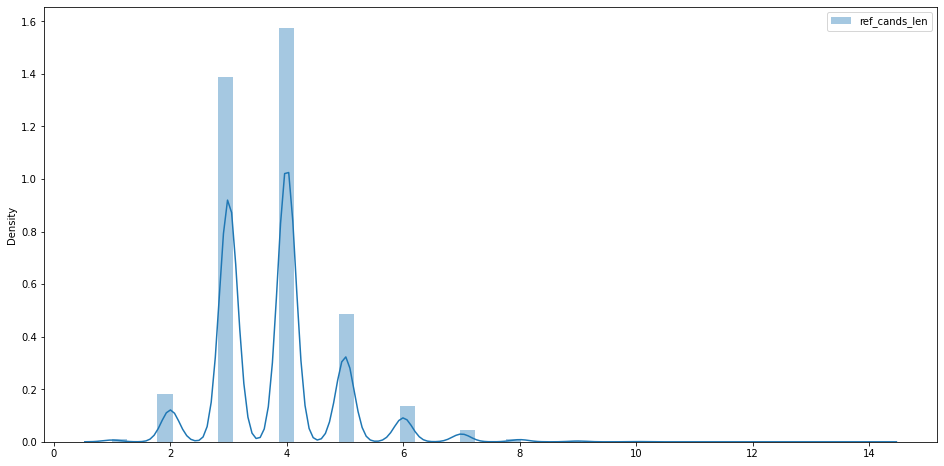

In [58]:
# bart_cands_len = [len(d) for d in bart_cands]
# gsum_cands_len = [len(d) for d in gsum_cands]
ref_cands_len = [len(d) for d in ref_cands]

plt.rcParams["figure.figsize"] = (16,8)

# sns.distplot(bart_cands_len, label='bart_cands_len')
# sns.distplot(gsum_cands_len, label='gsum_cands_len')
sns.distplot(ref_cands_len, label='ref_cands_len')

plt.legend()
# x_range = np.arange(0, 6, step=6 / 10).tolist()
# plt.xticks(x_range, \
#            ["{}".format(x) for x in x_range])

# fig.legend(labels=['refactor', 'gsum', 'bart'], fontsize=14)
plt.show()

In [75]:
sum_level_max_id = []
sent_level_max_id = []
for i, data in enumerate(data_list):
    abstract = data['abstract']
    candidates = data['candidates']
    max_id = np.argmax([get_rouge(abstract, cand[0]) for cand in candidates])
    sum_level_max_id.append(max_id)
    
    cand_sent = [(s, mid, get_rouge(abstract, [s])) for mid, cand in enumerate(candidates) for s in cand[0]]
    cand_sent = sorted(cand_sent, key= lambda x : x[-1], reverse=True)
    sent_level_max_id.append(cand_sent[0][1])
    print(i, max_id, cand_sent[0][1])

0 1 2
1 0 2
2 0 1
3 1 1
4 1 1
5 1 2
6 0 0
7 1 1
8 0 1
9 0 2
10 1 0
11 1 1
12 2 2
13 2 2
14 2 0
15 0 0
16 0 1
17 0 0
18 0 0
19 1 0
20 1 1
21 2 2
22 1 1
23 1 1
24 1 0
25 2 2
26 2 2
27 0 0
28 0 0
29 2 1
30 0 0
31 0 0
32 1 1
33 2 0
34 0 0
35 2 1
36 1 1
37 2 2
38 0 0
39 2 0
40 0 0
41 0 0
42 2 1
43 1 2
44 2 0
45 2 2
46 0 0
47 1 0
48 0 1
49 2 0
50 0 0
51 0 1
52 2 0
53 0 2
54 2 2
55 0 0
56 0 2
57 0 0
58 1 1
59 0 2
60 0 1
61 0 1
62 0 0
63 2 0
64 1 0
65 2 0
66 1 0
67 2 1
68 0 0
69 1 0
70 1 1
71 2 1
72 1 0
73 1 1
74 2 1
75 2 2
76 1 0
77 0 2
78 2 2
79 2 0
80 1 1
81 0 2
82 1 0
83 1 0
84 0 0
85 0 2
86 0 0
87 0 0
88 1 0
89 0 2
90 1 0
91 2 2
92 2 0
93 0 0
94 2 2
95 0 0
96 1 1
97 1 0
98 2 0
99 0 2
100 2 2
101 2 0
102 0 0
103 0 0
104 1 1
105 1 1
106 0 2
107 2 0
108 0 0
109 1 1
110 2 1
111 2 2
112 0 0
113 2 0
114 2 2
115 0 0
116 2 2
117 0 0
118 2 1
119 2 2
120 1 1
121 2 0
122 1 2
123 1 2
124 2 2
125 0 0
126 2 1
127 2 1
128 1 2
129 0 2
130 1 0
131 2 2
132 2 2
133 1 1
134 2 2
135 2 2
136 1 0
137 1 1
138 2 

1039 0 0
1040 2 0
1041 0 0
1042 2 0
1043 1 1
1044 0 0
1045 2 2
1046 1 0
1047 2 2
1048 0 2
1049 0 1
1050 1 1
1051 2 0
1052 2 0
1053 0 0
1054 0 0
1055 2 0
1056 0 2
1057 2 2
1058 1 0
1059 1 1
1060 1 1
1061 2 1
1062 0 1
1063 0 0
1064 0 0
1065 2 1
1066 0 0
1067 2 1
1068 2 2
1069 1 2
1070 2 2
1071 1 0
1072 0 1
1073 2 0
1074 2 1
1075 1 1
1076 0 0
1077 1 1
1078 1 0
1079 1 0
1080 0 0
1081 2 1
1082 2 1
1083 1 1
1084 1 2
1085 0 2
1086 1 2
1087 0 2
1088 2 0
1089 2 1
1090 0 0
1091 0 0
1092 2 0
1093 0 0
1094 0 0
1095 1 1
1096 2 0
1097 1 1
1098 2 1
1099 2 0
1100 2 2
1101 2 0
1102 0 1
1103 2 0
1104 1 1
1105 2 2
1106 2 1
1107 1 1
1108 2 1
1109 0 0
1110 1 1
1111 1 2
1112 1 0
1113 0 0
1114 2 2
1115 1 1
1116 0 2
1117 1 2
1118 1 1
1119 2 0
1120 0 2
1121 2 0
1122 0 1
1123 0 1
1124 1 1
1125 0 0
1126 1 1
1127 2 1
1128 2 2
1129 0 0
1130 1 2
1131 0 0
1132 0 2
1133 1 2
1134 1 2
1135 2 1
1136 0 0
1137 2 1
1138 1 1
1139 1 1
1140 0 0
1141 2 1
1142 2 0
1143 2 2
1144 1 1
1145 0 0
1146 1 1
1147 0 1
1148 0 0
1149 2 1
1

1953 2 0
1954 1 2
1955 0 0
1956 1 2
1957 2 2
1958 2 2
1959 1 1
1960 1 1
1961 2 1
1962 2 2
1963 1 1
1964 2 0
1965 0 2
1966 2 0
1967 2 0
1968 2 2
1969 1 1
1970 2 2
1971 2 1
1972 2 1
1973 1 1
1974 0 2
1975 0 0
1976 1 0
1977 1 1
1978 1 1
1979 2 0
1980 2 2
1981 1 1
1982 0 1
1983 1 1
1984 0 0
1985 2 2
1986 2 0
1987 1 0
1988 2 2
1989 2 2
1990 0 0
1991 2 2
1992 2 0
1993 2 2
1994 0 0
1995 1 1
1996 2 1
1997 2 1
1998 1 1
1999 0 1
2000 1 1
2001 1 2
2002 0 0
2003 1 0
2004 1 1
2005 0 2
2006 1 0
2007 2 0
2008 1 1
2009 1 1
2010 2 2
2011 1 0
2012 2 2
2013 1 0
2014 2 2
2015 1 2
2016 1 1
2017 2 1
2018 1 2
2019 0 0
2020 1 1
2021 1 2
2022 1 1
2023 2 2
2024 1 0
2025 2 1
2026 2 1
2027 0 2
2028 2 2
2029 2 2
2030 2 2
2031 1 2
2032 2 2
2033 1 2
2034 0 2
2035 1 0
2036 1 1
2037 0 2
2038 0 0
2039 0 0
2040 0 0
2041 2 0
2042 2 1
2043 0 1
2044 2 0
2045 2 2
2046 2 2
2047 2 2
2048 2 1
2049 2 1
2050 2 1
2051 2 1
2052 2 2
2053 1 1
2054 2 1
2055 2 0
2056 0 2
2057 1 1
2058 2 1
2059 0 0
2060 1 2
2061 1 0
2062 1 0
2063 1 1
2

2865 2 2
2866 0 0
2867 1 1
2868 2 1
2869 2 0
2870 1 0
2871 1 0
2872 1 1
2873 0 1
2874 2 2
2875 2 0
2876 1 1
2877 2 1
2878 1 1
2879 2 2
2880 0 0
2881 2 2
2882 1 2
2883 2 2
2884 0 0
2885 2 0
2886 1 2
2887 2 0
2888 0 2
2889 1 1
2890 2 2
2891 0 1
2892 0 0
2893 1 0
2894 0 2
2895 1 1
2896 1 1
2897 1 1
2898 1 1
2899 1 1
2900 1 1
2901 2 0
2902 2 1
2903 1 1
2904 2 0
2905 1 1
2906 2 2
2907 1 2
2908 0 0
2909 2 1
2910 0 0
2911 2 0
2912 2 1
2913 1 1
2914 2 0
2915 1 1
2916 0 1
2917 1 1
2918 0 0
2919 2 0
2920 2 2
2921 0 0
2922 0 1
2923 2 2
2924 0 0
2925 1 1
2926 2 0
2927 1 2
2928 0 0
2929 0 2
2930 0 0
2931 2 2
2932 2 0
2933 2 0
2934 2 2
2935 1 1
2936 1 1
2937 0 1
2938 1 1
2939 2 0
2940 0 0
2941 2 0
2942 1 2
2943 2 1
2944 0 1
2945 2 2
2946 2 1
2947 0 1
2948 2 0
2949 1 2
2950 0 0
2951 0 0
2952 0 0
2953 2 2
2954 0 0
2955 1 1
2956 2 2
2957 2 0
2958 1 2
2959 1 2
2960 1 0
2961 2 2
2962 2 2
2963 2 1
2964 0 0
2965 2 0
2966 0 1
2967 2 1
2968 0 0
2969 2 2
2970 1 1
2971 1 2
2972 0 0
2973 0 0
2974 0 0
2975 1 0
2

3779 0 2
3780 1 1
3781 2 0
3782 2 2
3783 2 2
3784 2 0
3785 0 0
3786 0 2
3787 0 2
3788 0 1
3789 1 0
3790 2 2
3791 1 1
3792 0 0
3793 0 0
3794 0 0
3795 1 2
3796 2 1
3797 2 2
3798 0 1
3799 1 1
3800 2 0
3801 0 1
3802 0 1
3803 1 2
3804 0 0
3805 0 2
3806 2 2
3807 1 1
3808 2 0
3809 2 2
3810 0 0
3811 2 2
3812 0 0
3813 0 2
3814 1 1
3815 2 2
3816 1 2
3817 2 0
3818 1 0
3819 2 2
3820 2 2
3821 2 2
3822 0 0
3823 1 2
3824 0 0
3825 2 1
3826 1 0
3827 0 2
3828 0 0
3829 1 1
3830 0 1
3831 0 0
3832 2 2
3833 2 2
3834 0 0
3835 1 0
3836 2 2
3837 0 0
3838 1 1
3839 1 0
3840 1 1
3841 2 1
3842 2 1
3843 0 2
3844 2 0
3845 1 1
3846 2 2
3847 2 2
3848 1 1
3849 2 2
3850 2 0
3851 2 2
3852 0 2
3853 2 1
3854 0 1
3855 1 0
3856 1 1
3857 1 1
3858 2 0
3859 0 0
3860 0 2
3861 2 0
3862 0 0
3863 2 1
3864 1 1
3865 1 1
3866 0 2
3867 2 2
3868 2 0
3869 1 0
3870 2 2
3871 0 2
3872 1 2
3873 0 1
3874 2 1
3875 1 2
3876 1 1
3877 0 0
3878 0 1
3879 1 1
3880 2 1
3881 0 1
3882 2 2
3883 1 0
3884 1 1
3885 2 0
3886 2 2
3887 1 2
3888 0 0
3889 1 1
3

4694 2 0
4695 2 0
4696 2 1
4697 1 2
4698 2 2
4699 0 0
4700 1 0
4701 0 0
4702 0 2
4703 2 2
4704 0 2
4705 1 2
4706 2 0
4707 1 0
4708 2 2
4709 2 2
4710 0 2
4711 2 2
4712 2 1
4713 0 1
4714 0 2
4715 1 1
4716 1 2
4717 1 0
4718 1 1
4719 1 1
4720 0 0
4721 2 0
4722 0 0
4723 0 1
4724 2 2
4725 2 2
4726 2 2
4727 2 1
4728 0 2
4729 0 1
4730 0 0
4731 2 1
4732 0 1
4733 0 0
4734 0 0
4735 1 0
4736 1 1
4737 0 1
4738 0 0
4739 2 1
4740 2 0
4741 1 1
4742 2 2
4743 0 0
4744 2 1
4745 2 2
4746 2 2
4747 0 0
4748 0 0
4749 1 1
4750 2 2
4751 0 2
4752 1 1
4753 0 0
4754 1 0
4755 0 2
4756 2 2
4757 0 0
4758 2 0
4759 2 0
4760 0 0
4761 0 0
4762 2 0
4763 0 0
4764 0 0
4765 0 0
4766 0 1
4767 1 2
4768 1 0
4769 2 2
4770 1 1
4771 2 0
4772 2 2
4773 2 0
4774 1 1
4775 2 2
4776 2 1
4777 1 2
4778 2 1
4779 2 2
4780 1 1
4781 2 2
4782 2 1
4783 1 1
4784 2 2
4785 2 1
4786 2 1
4787 1 1
4788 0 0
4789 2 0
4790 0 0
4791 0 1
4792 2 2
4793 0 0
4794 1 0
4795 2 2
4796 0 1
4797 0 0
4798 0 0
4799 0 0
4800 0 2
4801 1 1
4802 0 0
4803 2 0
4804 2 0
4

5606 2 1
5607 2 0
5608 0 0
5609 0 0
5610 1 1
5611 0 0
5612 0 0
5613 2 0
5614 2 2
5615 1 0
5616 1 1
5617 2 0
5618 0 0
5619 1 1
5620 0 0
5621 2 2
5622 2 1
5623 1 1
5624 1 1
5625 0 1
5626 0 0
5627 2 1
5628 1 1
5629 2 2
5630 0 0
5631 0 0
5632 1 2
5633 0 0
5634 2 2
5635 2 2
5636 1 0
5637 2 0
5638 2 1
5639 2 2
5640 2 1
5641 1 0
5642 2 0
5643 2 2
5644 2 2
5645 2 0
5646 2 1
5647 1 0
5648 2 2
5649 2 1
5650 0 0
5651 2 2
5652 0 0
5653 2 2
5654 0 0
5655 0 1
5656 0 0
5657 0 1
5658 2 2
5659 2 2
5660 0 1
5661 0 1
5662 1 0
5663 2 1
5664 2 0
5665 1 0
5666 2 2
5667 0 0
5668 0 1
5669 1 0
5670 2 2
5671 1 1
5672 0 2
5673 0 1
5674 2 2
5675 0 2
5676 2 0
5677 2 2
5678 1 0
5679 0 0
5680 1 2
5681 0 0
5682 1 2
5683 2 0
5684 0 0
5685 2 1
5686 2 2
5687 2 1
5688 2 1
5689 1 1
5690 0 1
5691 1 2
5692 0 1
5693 2 2
5694 1 0
5695 1 2
5696 0 0
5697 2 2
5698 1 1
5699 0 1
5700 2 2
5701 2 1
5702 0 0
5703 2 0
5704 2 0
5705 0 1
5706 2 0
5707 0 0
5708 2 2
5709 1 1
5710 0 0
5711 1 1
5712 1 0
5713 0 0
5714 0 0
5715 1 0
5716 2 2
5

6518 0 0
6519 2 2
6520 2 0
6521 1 1
6522 0 1
6523 1 1
6524 2 2
6525 2 0
6526 2 0
6527 1 1
6528 2 2
6529 2 1
6530 0 0
6531 1 0
6532 2 2
6533 2 0
6534 2 2
6535 0 0
6536 1 0
6537 0 0
6538 2 2
6539 0 2
6540 1 0
6541 2 1
6542 2 0
6543 2 1
6544 2 2
6545 1 1
6546 1 1
6547 0 0
6548 2 2
6549 2 0
6550 2 2
6551 0 2
6552 1 2
6553 1 2
6554 2 2
6555 1 2
6556 1 1
6557 2 2
6558 1 1
6559 1 0
6560 1 0
6561 2 0
6562 1 1
6563 1 1
6564 0 2
6565 1 1
6566 0 1
6567 2 2
6568 2 1
6569 0 0
6570 2 2
6571 0 1
6572 0 2
6573 2 2
6574 2 2
6575 0 0
6576 1 1
6577 2 1
6578 1 0
6579 0 0
6580 1 2
6581 1 1
6582 2 0
6583 0 0
6584 1 1
6585 1 1
6586 0 0
6587 1 1
6588 1 1
6589 0 0
6590 1 1
6591 2 2
6592 0 2
6593 1 2
6594 2 0
6595 1 2
6596 0 1
6597 2 1
6598 1 0
6599 1 2
6600 0 1
6601 1 0
6602 1 2
6603 2 2
6604 2 2
6605 2 2
6606 0 0
6607 2 2
6608 1 1
6609 2 0
6610 1 2
6611 0 2
6612 2 1
6613 1 0
6614 0 0
6615 0 0
6616 1 0
6617 2 0
6618 2 1
6619 0 0
6620 2 2
6621 1 0
6622 2 0
6623 1 1
6624 0 0
6625 0 2
6626 2 1
6627 1 1
6628 2 0
6

7429 2 1
7430 1 1
7431 1 2
7432 0 2
7433 2 2
7434 1 1
7435 1 1
7436 2 2
7437 0 1
7438 1 1
7439 0 0
7440 2 2
7441 0 2
7442 2 0
7443 1 1
7444 1 1
7445 2 2
7446 0 0
7447 2 2
7448 1 1
7449 2 0
7450 2 2
7451 2 1
7452 2 2
7453 2 0
7454 2 0
7455 2 0
7456 1 1
7457 1 1
7458 0 1
7459 0 0
7460 1 1
7461 1 1
7462 2 0
7463 0 1
7464 0 2
7465 0 0
7466 2 2
7467 0 0
7468 0 1
7469 1 1
7470 1 1
7471 2 0
7472 1 1
7473 0 0
7474 0 0
7475 0 0
7476 2 0
7477 0 0
7478 2 1
7479 2 0
7480 0 0
7481 0 0
7482 0 0
7483 1 1
7484 2 2
7485 0 0
7486 1 1
7487 1 1
7488 1 2
7489 2 2
7490 0 0
7491 1 0
7492 2 2
7493 2 0
7494 1 1
7495 0 0
7496 0 0
7497 1 1
7498 1 1
7499 2 1
7500 0 0
7501 2 2
7502 0 1
7503 1 2
7504 1 2
7505 0 0
7506 1 0
7507 2 2
7508 1 1
7509 1 2
7510 2 2
7511 0 0
7512 2 2
7513 0 2
7514 1 1
7515 0 0
7516 0 1
7517 0 0
7518 2 2
7519 1 1
7520 0 1
7521 1 1
7522 1 2
7523 2 0
7524 0 0
7525 0 0
7526 2 2
7527 0 2
7528 2 2
7529 2 0
7530 0 0
7531 1 1
7532 2 0
7533 1 0
7534 1 0
7535 0 0
7536 1 1
7537 2 0
7538 1 2
7539 0 1
7

8346 1 1
8347 0 0
8348 1 1
8349 2 0
8350 1 1
8351 2 0
8352 0 0
8353 2 2
8354 2 1
8355 0 1
8356 1 1
8357 2 2
8358 0 0
8359 2 0
8360 0 0
8361 2 2
8362 1 1
8363 0 1
8364 1 1
8365 0 0
8366 1 0
8367 2 2
8368 2 1
8369 1 2
8370 1 1
8371 2 0
8372 0 2
8373 1 0
8374 2 1
8375 1 1
8376 2 2
8377 1 0
8378 1 0
8379 2 2
8380 1 0
8381 2 0
8382 2 2
8383 1 0
8384 1 0
8385 0 0
8386 0 0
8387 1 1
8388 0 2
8389 1 1
8390 1 2
8391 2 0
8392 2 1
8393 2 1
8394 2 1
8395 0 2
8396 0 0
8397 2 2
8398 1 2
8399 1 0
8400 1 2
8401 2 2
8402 1 2
8403 1 1
8404 2 0
8405 2 0
8406 1 0
8407 0 2
8408 1 1
8409 2 1
8410 1 1
8411 1 1
8412 0 0
8413 1 2
8414 1 1
8415 1 1
8416 0 0
8417 0 1
8418 0 2
8419 0 0
8420 0 0
8421 1 1
8422 0 2
8423 0 0
8424 0 2
8425 2 2
8426 2 2
8427 2 0
8428 0 0
8429 0 2
8430 1 1
8431 2 0
8432 2 0
8433 0 0
8434 0 0
8435 0 0
8436 0 2
8437 1 1
8438 1 1
8439 0 0
8440 1 2
8441 2 2
8442 2 1
8443 0 0
8444 2 0
8445 0 0
8446 1 1
8447 1 1
8448 2 1
8449 0 0
8450 0 0
8451 2 0
8452 2 2
8453 2 0
8454 2 1
8455 0 1
8456 2 0
8

9257 0 0
9258 0 0
9259 2 1
9260 0 0
9261 2 1
9262 2 0
9263 1 1
9264 2 0
9265 2 2
9266 2 2
9267 1 1
9268 2 2
9269 0 0
9270 2 0
9271 1 0
9272 0 2
9273 0 2
9274 2 1
9275 1 1
9276 0 0
9277 2 2
9278 2 2
9279 2 1
9280 2 2
9281 1 0
9282 1 0
9283 2 0
9284 2 0
9285 1 2
9286 0 0
9287 1 1
9288 2 0
9289 0 0
9290 2 1
9291 1 1
9292 2 0
9293 2 2
9294 1 1
9295 1 1
9296 0 2
9297 1 1
9298 2 2
9299 0 0
9300 1 1
9301 1 1
9302 2 2
9303 1 0
9304 0 1
9305 0 0
9306 1 1
9307 0 2
9308 2 2
9309 0 0
9310 2 0
9311 2 2
9312 0 1
9313 0 0
9314 0 0
9315 2 0
9316 2 1
9317 2 2
9318 0 2
9319 1 1
9320 1 1
9321 1 1
9322 2 2
9323 1 0
9324 0 0
9325 1 0
9326 2 2
9327 2 1
9328 2 2
9329 0 0
9330 2 2
9331 2 0
9332 2 0
9333 2 1
9334 1 1
9335 0 0
9336 0 0
9337 0 0
9338 0 2
9339 1 0
9340 2 0
9341 1 1
9342 2 2
9343 2 1
9344 2 2
9345 1 0
9346 0 0
9347 0 0
9348 1 0
9349 0 0
9350 1 1
9351 2 1
9352 2 0
9353 1 1
9354 2 2
9355 1 1
9356 1 1
9357 1 1
9358 2 2
9359 2 0
9360 0 1
9361 0 1
9362 2 2
9363 2 0
9364 0 0
9365 1 2
9366 2 2
9367 1 2
9

10155 0 1
10156 2 0
10157 2 2
10158 1 1
10159 0 2
10160 1 0
10161 1 1
10162 2 0
10163 1 1
10164 1 2
10165 2 0
10166 2 2
10167 2 1
10168 0 1
10169 1 1
10170 1 1
10171 1 1
10172 0 1
10173 1 1
10174 0 0
10175 2 1
10176 0 1
10177 2 1
10178 2 2
10179 0 0
10180 0 0
10181 2 1
10182 1 0
10183 1 0
10184 0 0
10185 2 1
10186 1 1
10187 1 1
10188 1 0
10189 1 1
10190 2 0
10191 1 0
10192 1 0
10193 2 0
10194 1 0
10195 0 0
10196 2 0
10197 2 1
10198 1 1
10199 1 0
10200 1 1
10201 2 2
10202 1 1
10203 0 1
10204 0 0
10205 0 0
10206 0 0
10207 2 0
10208 1 0
10209 0 2
10210 1 1
10211 1 2
10212 1 1
10213 0 1
10214 2 2
10215 2 1
10216 0 1
10217 0 0
10218 1 0
10219 0 0
10220 1 1
10221 2 0
10222 2 0
10223 0 0
10224 0 0
10225 1 1
10226 2 2
10227 2 1
10228 1 1
10229 2 0
10230 1 2
10231 0 2
10232 0 2
10233 2 2
10234 2 0
10235 1 1
10236 2 1
10237 2 2
10238 2 0
10239 1 0
10240 1 2
10241 2 2
10242 2 2
10243 1 0
10244 1 0
10245 1 1
10246 0 0
10247 1 2
10248 1 1
10249 2 0
10250 2 2
10251 1 0
10252 0 0
10253 1 1
10254 0 0


10978 0 2
10979 1 1
10980 1 1
10981 0 0
10982 0 1
10983 2 2
10984 0 2
10985 1 1
10986 0 0
10987 0 1
10988 2 2
10989 1 0
10990 1 1
10991 0 0
10992 1 1
10993 1 1
10994 2 0
10995 2 2
10996 0 1
10997 2 1
10998 0 0
10999 2 2
11000 1 0
11001 1 0
11002 1 1
11003 2 0
11004 1 0
11005 1 0
11006 2 2
11007 2 2
11008 0 0
11009 2 2
11010 0 0
11011 2 0
11012 0 0
11013 2 1
11014 2 2
11015 2 2
11016 2 2
11017 1 1
11018 1 1
11019 2 2
11020 1 1
11021 0 0
11022 0 1
11023 2 0
11024 1 0
11025 2 1
11026 1 1
11027 0 2
11028 1 0
11029 2 1
11030 1 2
11031 2 1
11032 0 0
11033 2 2
11034 0 1
11035 0 0
11036 2 2
11037 0 2
11038 2 0
11039 2 0
11040 1 0
11041 2 2
11042 1 0
11043 2 0
11044 2 2
11045 2 2
11046 1 2
11047 2 2
11048 2 2
11049 2 1
11050 0 0
11051 1 1
11052 2 2
11053 2 2
11054 2 2
11055 0 2
11056 1 1
11057 2 1
11058 2 2
11059 2 2
11060 1 0
11061 1 0
11062 2 2
11063 1 1
11064 2 2
11065 2 2
11066 0 0
11067 0 0
11068 2 1
11069 2 2
11070 1 2
11071 0 0
11072 0 0
11073 0 0
11074 2 0
11075 1 1
11076 1 1
11077 2 1


In [101]:
sents_score = []
diff_g_r = []
diff_b_r = []
diff_g_b = []

for i, data in enumerate(data_list):
    abstract = data['abstract']
    candidates = data['candidates']
    
    g_rou = get_rouge(abstract, candidates[2][0])
    b_rou = get_rouge(abstract, candidates[1][0])
    r_rou = get_rouge(abstract, candidates[0][0])
    
    diff_g_r.append(g_rou - r_rou)
    diff_b_r.append(b_rou - r_rou)
    diff_g_b.append(g_rou - b_rou)
    
    sents_score +=[(mid, get_rouge(abstract, [s])) for mid, cand in enumerate(candidates) for s in cand[0]]
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063


3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705


5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346


6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990


8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632


10060
10061
10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
1022

11433
11434
11435
11436
11437
11438
11439
11440
11441
11442
11443
11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489


In [102]:
bart_s_s =[s[1] for s in sents_score if s[0]==1]
gsum_s_s =[s[1] for s in sents_score if s[0]==2]
ref_s_s =[s[1] for s in sents_score if s[0]==0]

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

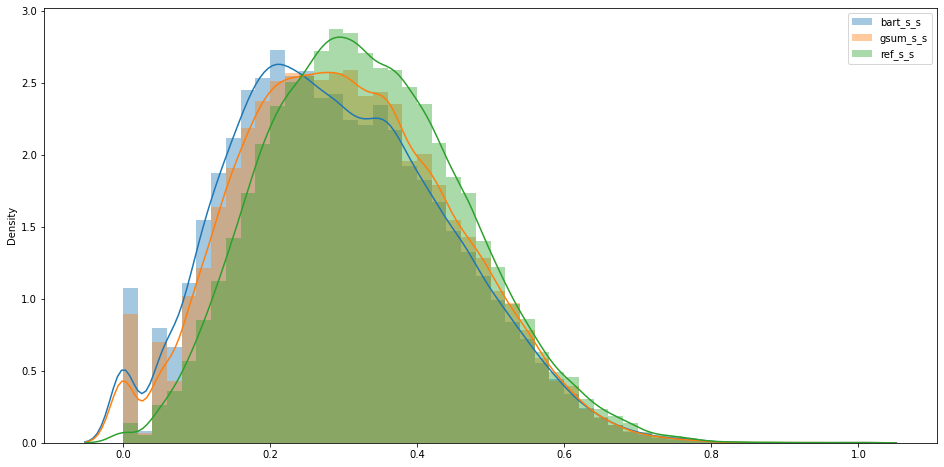

In [103]:
plt.rcParams["figure.figsize"] = (16,8)

sns.distplot(bart_s_s, label='bart_s_s')
sns.distplot(gsum_s_s, label='gsum_s_s')
sns.distplot(ref_s_s, label='ref_s_s')

plt.legend()
plt.show()

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


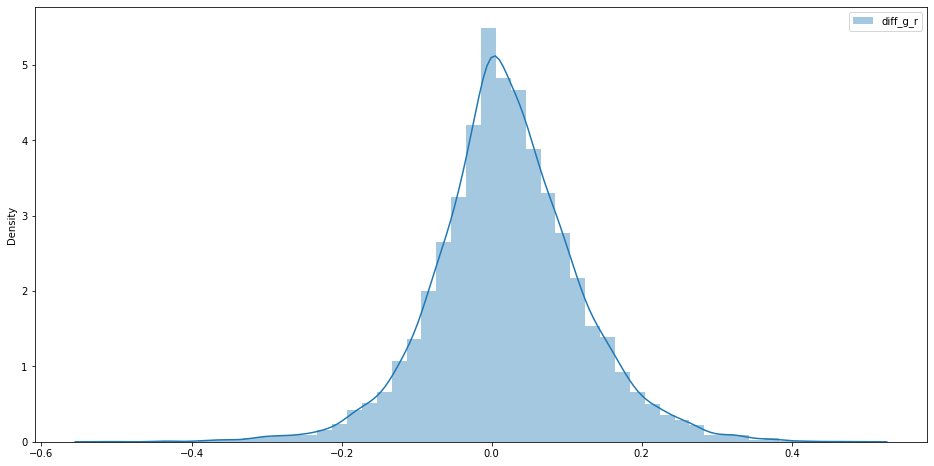

In [114]:
plt.rcParams["figure.figsize"] = (16,8)
di = [diff_g_r[i]-diff_b_r[i] for i in range(len(diff_b_r))]
# plt.plot(diff_g_b, label='diff_g_r')
# plt.plot(, label='diff_g_b')
sns.distplot(diff_g_b, label='diff_g_r')
plt.legend()
plt.show()

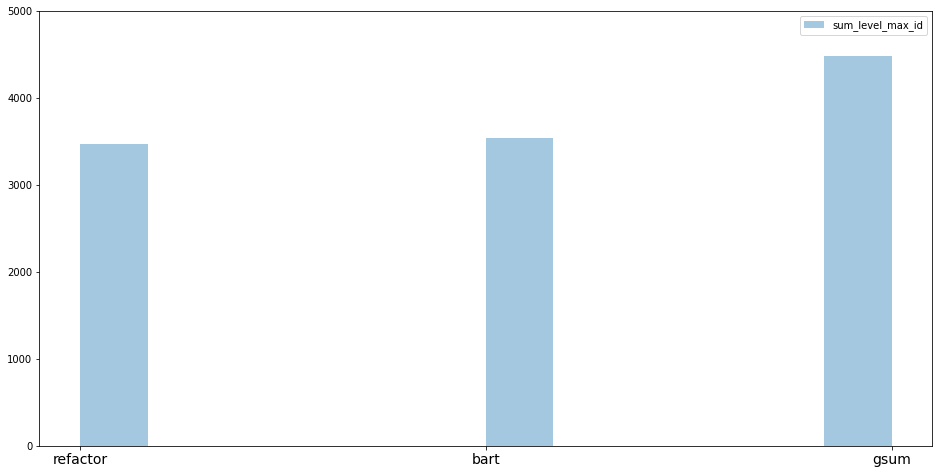

In [89]:
plt.rcParams["figure.figsize"] = (16,8)

model_name = {0 : 'refactor', 1: 'bart', 2: 'gsum'}

sns.distplot(sum_level_max_id, label='sum_level_max_id', kde=False)

y_range = np.arange(0, 5001, step=1000).tolist()
plt.yticks(y_range, \
           ["{}".format(int(y)) for y in y_range])

x_range = np.arange(0, 3, step=1).tolist()
plt.xticks(x_range, \
           [model_name[x] for x in x_range], fontsize=14)

plt.legend()
plt.show()

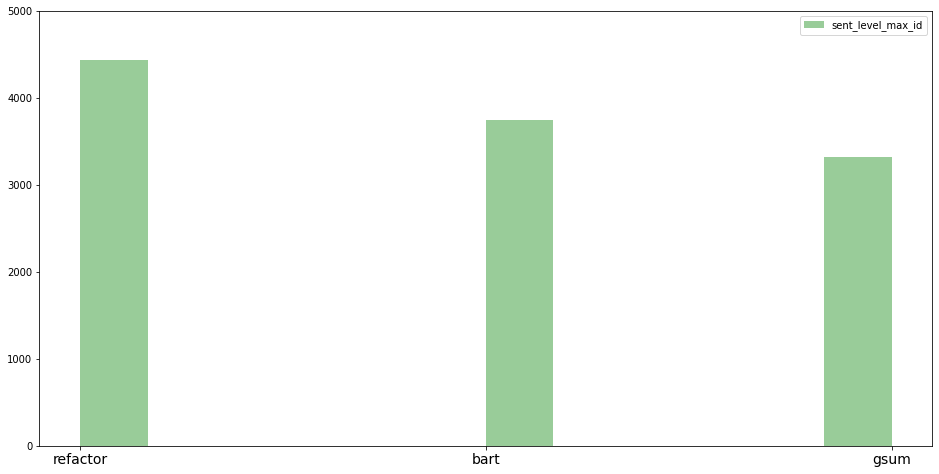

In [92]:
plt.rcParams["figure.figsize"] = (16,8)

sns.distplot(sent_level_max_id, label='sent_level_max_id', kde=False, color='g')
y_range = np.arange(0, 5001, step=1000).tolist()
plt.yticks(y_range, \
           ["{}".format(int(y)) for y in y_range])

x_range = np.arange(0, 3, step=1).tolist()
plt.xticks(x_range, \
           [model_name[x] for x in x_range], fontsize=14)

plt.legend()
plt.show()